In [85]:
import os
os.environ['USER_AGENT'] = 'RAGUserAgent'
import openai
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import chromadb
from langchain_community.vectorstores import Chroma
from langchain_core.runnables import RunnableParallel
from dotenv import load_dotenv, find_dotenv
from langchain_core.prompts import PromptTemplate
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain_community.retrievers import BM25Retriever
from langchain.retrievers import EnsembleRetriever
from langchain_community.vectorstores import FAISS
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool
from typing import Annotated, Literal, Sequence, TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.prebuilt import tools_condition
from langgraph.graph import END, StateGraph
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
import pprint
from langchain_core.output_parsers import StrOutputParser
from typing import List, Optional, Dict

In [30]:
str_output_parser = StrOutputParser()

In [19]:
_ = load_dotenv(dotenv_path='env.txt')
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
openai.api_key = os.environ['OPENAI_API_KEY']
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)
agent_llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)
embedding_function = OpenAIEmbeddings()

In [20]:
vectorstore = FAISS.load_local("nba_vector_db_semantic", embeddings=embedding_function, allow_dangerous_deserialization=True)
documents = vectorstore.docstore._dict.values()
dense_retriever = vectorstore.as_retriever(search_kwargs={"k": 10})
sparse_retriever = BM25Retriever.from_documents(list(documents), k=10)
ensemble_retriever = EnsembleRetriever(retrievers=[dense_retriever, sparse_retriever], weights=[0.5, 0.5], c=0)

In [21]:
_ = load_dotenv(dotenv_path='env.txt')
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')
!export TAVILY_API_KEY=os.environ['TAVILY_API_KEY']
web_search = TavilySearchResults(max_results=4)
web_search_name = web_search.name

'export' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [44]:
retriever_tool = create_retriever_tool(
    ensemble_retriever,
    "retrieve_NBA_Player_question_answers",
    "Extensive information about NBA players.",
)
retriever_tool_name = retriever_tool.name

In [45]:
tools = [web_search, retriever_tool]

In [76]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    loop_count: int  # NEW: add a loop counter

In [134]:
generation_prompt = PromptTemplate.from_template(
    """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer 
    the question. If you don't know the answer, just say 
    that you don't know. Provide a thorough description to 
    fully answer the question, utilizing any relevant 
    information you find. Finally, translate the answer into Chiniese and only return the Chinese translation.
    
    Question: {question} 
    Context: {context} 
    
    Answer:"""
)

In [135]:
def score_documents(state) -> Literal["generate", "improve"]:

    print("---CHECK RELEVANCE---")

    # Data model - returns a binary score for the relevance check
    class scoring(BaseModel):
        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM with tool and validation
    llm_with_tool = llm.with_structured_output(scoring)

    # Prompt
    prompt = PromptTemplate(
        template="""
        You are assessing relevance of a retrieved document to a user question with a binary grade. \n 
        
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """,
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "improve"

In [136]:
def agent(state):
    print("---CALL AGENT---")
    messages = state["messages"]
    llm = agent_llm.bind_tools(tools)
    response = llm.invoke(messages)
    return {"messages": [response]} # Return list, will get added to existing list

In [137]:
def improve(state):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(content=f"""\n 
            Look at the input and try to reason about the underlying semantic intent / meaning. \n 
            Here is the initial question:
            \n ------- \n
            {question} 
            \n ------- \n
            Formulate an improved question: 
            """,
        )
    ]

    response = llm.invoke(msg)

    return {
        "messages": [response],
        "loop_count": state.get("loop_count", 0) + 1  # increment loop counter
    }

In [138]:
def generate(state):
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    # Chain
    rag_chain = generation_prompt | llm | str_output_parser

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [139]:
def tools_condition(state: AgentState) -> str:
    loop_count = state.get("loop_count", 0)

    # Safety stop condition
    if loop_count >= 10:
        print(f"---LOOP COUNT {loop_count} REACHED, EXITING---")
        return END

    # Default behavior: go retrieve
    return "tools"


In [140]:
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode(tools)
workflow.add_node("retrieve", retrieve)  # retrieval from web and or retriever
workflow.add_node("improve", improve)  # Improving the question for better retrieval
workflow.add_node("generate", generate)  # Generating a response after we know the documents are relevant

# Call agent node to decide to retrieve or not
workflow.set_entry_point("agent")

# Decide whether to retrieve (assess agent decision)
workflow.add_conditional_edges("agent", tools_condition, 
    # Translate the condition outputs to nodes in our graph
    {
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called (assess agent decision)
workflow.add_conditional_edges("retrieve", score_documents)
workflow.add_edge("generate", END)
workflow.add_edge("improve", "agent")

# Compile
graph = workflow.compile()

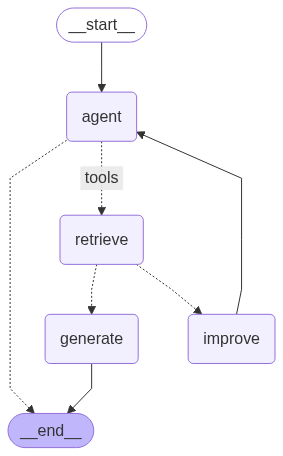

In [141]:
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [132]:
import pprint
inputs = {
    "messages": [
        ("user", "Who is the Final MVP in year of 2022?"),
    ],
    "loop_count": 0  # Must initialize this field
}


final_answer = ''
for output in graph.stream(inputs, config={"recursion_limit": 50}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
        final_answer = value
    pprint.pprint("\n---\n")




---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_kngOZHLzZ6XmsHt4kFxgG4MR', 'function': {'arguments': '{"query":"2022 NBA Finals MVP"}', 'name': 'retrieve_NBA_Player_question_answers'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c'}, id='run--5a37aa95-916e-465f-9e00-cfef82798ef8-0', tool_calls=[{'name': 'retrieve_NBA_Player_question_answers', 'args': {'query': '2022 NBA Finals MVP'}, 'id': 'call_kngOZHLzZ6XmsHt4kFxgG4MR', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='He is a three-time NBA All-Star, a five-time NBA All-Defensive Team honoree, and he helped the Heat reach the NBA Finals in 2020 and 2023. He also won a gold medal with the 2020 and 2024 U.S.\n\n= Regular seas

In [133]:
final_answer['messages'][0]

"The NBA Finals MVP for the year 2022 was Stephen Curry. He played a crucial role in leading the Golden State Warriors to victory in the NBA Finals against the Boston Celtics. This marked Curry's first Finals MVP award, despite his previous successes, including multiple NBA championships and regular season MVP awards. His performance throughout the Finals was outstanding, showcasing his scoring ability, playmaking, and leadership on the court.\n\nIn the decisive Game 6 of the Finals, Curry scored 34 points, helping the Warriors clinch the championship. His contributions were pivotal in the series, and he was recognized for his excellence with the Finals MVP award, solidifying his legacy as one of the greatest players in NBA history.\n\n**Translation in Chinese:**\n2022年的NBA总决赛最有价值球员（MVP）是斯蒂芬·库里。他在带领金州勇士队战胜波士顿凯尔特人队的NBA总决赛中发挥了关键作用。这是库里首次获得总决赛MVP奖，尽管他之前已经取得了多次NBA冠军和常规赛MVP奖。他在总决赛中的表现非常出色，展示了他的得分能力、组织进攻能力和场上的领导力。\n\n在总决赛的决定性第六场比赛中，库里得到了34分，帮助勇士队夺得冠军。他在整个系列赛中的贡献至关重要，因此获得了总决赛MVP奖，巩固了他作为NBA历史上

In [ ]:
result = graph.invoke(inputs, config={"recursion_limit": 15})

final_message = result["messages"][-1]  # Last message from generate()
print("Final Answer:", final_message.content)


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
Final Answer: Michael Jordan has won more NBA championships than LeBron James. Michael Jordan secured a total of six NBA championships during his career, all with the Chicago Bulls, winning titles in the years 1991, 1992, 1993, 1996, 1997, and 1998. In contrast, LeBron James has won four NBA championships. He won his titles with three different teams: two with the Miami Heat in 2012 and 2013, one with the Cleveland Cavaliers in 2016, and one with the Los Angeles Lakers in 2020.

While both players are often compared in discussions about the greatest basketball players of all time, Jordan's six championships give him an edge in that specific category. LeBron has made ten NBA Finals appearances, which is notable, but his championship count currently stands at four.


In [118]:
import gradio as gr

In [142]:
def process_question(question):
    inputs = {
        "messages": [("user", question)],
        "loop_count": 0  # Required to control LangGraph recursion
    }

    # Invoke the compiled LangGraph
    result = graph.invoke(inputs, config={"recursion_limit": 15})

    # Extract the final message from state
    final_answer = ""
    if "messages" in result and result["messages"]:
        final_answer = result["messages"][-1].content
    else:
        final_answer = "No answer generated."


    return final_answer

# ✅ Build the Gradio Interface
demo = gr.Interface(
    fn=process_question,
    inputs=gr.Textbox(label="Enter your question"),
    outputs=[
        gr.Textbox(label="Final Answer")
    ],
    title="NBA Player Question Answering (RAG Agent)",
    description="Ask questions about NBA players. The agent will retrieve documents and generate a final answer."
)

In [143]:
demo.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---
Created dataset file at: .gradio\flagged\dataset1.csv
